In [1]:
s_model='ir2' #ir2, res50, in3
isKfold=0
import math
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 8
rcParams['xtick.color'] = 'w'
rcParams['ytick.color'] = 'w'
rcParams['axes.labelcolor'] = 'w'

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn import metrics

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if s_model=='in3':
    from keras.applications.inception_v3 import InceptionV3, preprocess_input

if s_model=='res50':
    from keras.applications.resnet50 import ResNet50, preprocess_input

if s_model=='ir2':
    from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

    
from keras.models import Model
from keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import os
import glob

Using TensorFlow backend.


In [2]:
def kmeans(ori_img):
    Z = ori_img.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 4, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z, K, None, criteria, 4,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((ori_img.shape))
    np.unique(res2[:,:,1])
    temp = res2
    temp[:,:,0][res2[:,:,0] > np.unique(res2[:,:,0])[0]] = 255
    temp[:,:,1][res2[:,:,1] > np.unique(res2[:,:,1])[0]] = 255
    temp[:,:,2][res2[:,:,2] > np.unique(res2[:,:,2])[0]] = 255
    newx = ori_img
    newx[:,:,0][temp[:,:,0]== 255] = 255
    newx[:,:,1][temp[:,:,1]== 255] = 255
    newx[:,:,2][temp[:,:,2]== 255] = 255
    return newx

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
categorie =['abnormal','normal']
# categorie =['black','broken','fungus','insect','ng','normal']
# categorie =['black','broken','fungus','insect','normal']
if s_model == 'ir2':
    image_size_shape=(299, 299)
if s_model == 'res50':
    image_size_shape=(224, 224)    

def load_data(path):
    x_train = []
    y_train = []
    
    images = glob.glob(path+"/**/*")
    for i,photo in enumerate(images):
        img = load_img(photo, target_size=image_size_shape)
        tr_x = img_to_array(img)
#         tr_x = kmeans(tr_x)
        tr_x = preprocess_input(tr_x)
        label = (photo.split("/"))[2]
        label_place = categorie.index(label)
        x_train.append(tr_x)
        y_train.append(label_place)
        
    return np.array(x_train), y_train

6310
(6310, 2)
(6310, 224, 224, 3)
6310.0


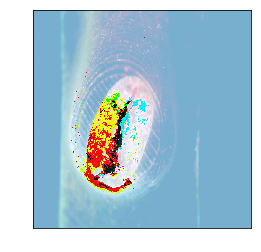

In [20]:
trainImages, y_Lable = load_data('datasets/train')
print(len(y_Lable))
y_Lable = keras.utils.to_categorical(y_Lable)
print(y_Lable.shape)
print(trainImages.shape)
print(y_Lable.sum())
plt.imshow(((trainImages[-1]+1.)* 127.5).astype(np.uint8), cmap='gray')

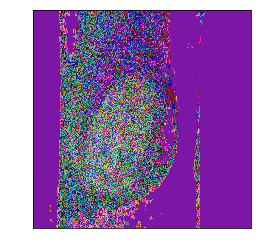

In [23]:
# print(y_Lable[10,:])
# print(trainImages[10,:])
# print(y_Lable[:,1].sum())
plt.imshow((trainImages[-5]*255).astype(np.uint8), cmap='gray')

In [6]:
np.random.seed(2016)
#Shuffle the dataset
trainImages, y_Lable = shuffle(trainImages, y_Lable, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(trainImages, 
                                                    y_Lable, 
                                                    test_size = 0.2, 
                                                    stratify  = y_Lable)
img = trainImages[0].flatten()

print('input_data shape: training {training_shape}'.format(
            training_shape=(len(x_train), img.shape[0])))
print('x_train shape: training {training_shape}'.format(
            training_shape=x_train.shape))
print('y_train shape: training {training_shape}'.format(
            training_shape=y_train.shape))
print('x_test shape: training {training_shape}'.format(
            training_shape=x_test.shape))
print('y_test shape: training {training_shape}'.format(
            training_shape=y_test.shape))

input_data shape: training (5048, 150528)
x_train shape: training (5048, 224, 224, 3)
y_train shape: training (5048, 2)
x_test shape: training (1262, 224, 224, 3)
y_test shape: training (1262, 2)


In [7]:
batch_size = 32
num_classes = y_Lable.shape[1]
epochs = 200
dr_rate=0.5
l1_r = 1e-5
l2_r = 1e-5
lr=1e-5
decay=1e-6
momentum=0.9
steps_per_epoch= math.floor(trainImages.shape[0] / batch_size)
patience=10
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = s_model + 'transfer_learning.h5'

FC_SIZE = 2048
LAYERS_TO_FREEZE = 'conv2d_118'
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

In [8]:
#create LossHistory class，keep loss and acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            
        plt.grid(True)
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel(loss_type)
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # loss
        plt.plot(iters, self.losses[loss_type], 'r', label='train loss')
        if loss_type == 'epoch':
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'b', label='val loss')
            
        plt.grid(True)
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend(['train', 'test'],loc='best')
        plt.show()   

In [9]:
learning_rate_function = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-6)

In [11]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    print('num of layers ', len(base_model.layers))
#     for layer in base_model.layers:
#         layer.trainable = False
            
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(modelType, base_model, nb_classes, FC_SIZE):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    
    if modelType=='res50':
        x = base_model.output
#         x = Flatten()(x)
#         x = Dense(FC_SIZE, activation='relu')(x)
#         x = Dropout(dr_rate)(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(FC_SIZE, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=l1_r,l2=l2_r))(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        x = Dense(FC_SIZE, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=l1_r,l2=l2_r))(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        predictions = Dense(num_classes, activation='softmax')(x) #new softmax layer
        model = Model(input=base_model.input, output=predictions) 
    elif modelType=='in3':
        tensorInput=Input(shape=x_train.shape[1:])
#         x = base_model.output
        bn = BatchNormalization()(tensorInput)
        x = base_model(bn)
        x = GlobalAveragePooling2D()(x)
        x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
        model = Model(input=tensorInput, output=predictions)
#         model = Model(input=base_model.input, output=predictions)
    elif modelType=='ir2':
        x = base_model.output  
#         bn = BatchNormalization()(tensor_input)
#         x = base_model(bn)
#         x = Convolution2D(FC_SIZE, (4, 4),
#                       strides=(1, 1),
#                       padding='valid',
#                       use_bias=False)(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)     
#         x = GlobalAveragePooling2D()(x)
        x = GlobalMaxPooling2D()(x)
        x = Dense(FC_SIZE, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=l1_r,l2=l2_r))(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        x = Dense(FC_SIZE, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=l1_r,l2=l2_r))(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        predictions = Dense(num_classes, activation='sigmoid')(x)#activation='softmax')(x)  
        model = Model(input=base_model.input, output=predictions)
    
    return model


def setup_to_finetune(model, LAYERS_TO_FREEZE):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
    Args:
    model: keras model
    """
    # Unfreeze everything first
    for layer in model.layers:
        layer.trainable = True
    # Then freeze all the layers back until the target layer
    for layer in model.layers:
        if layer.name == LAYERS_TO_FREEZE:
            break
        layer.trainable = False
#     for layer in model.layers[:LAYERS_TO_FREEZE]:
#         layer.trainable = False #權重不更新
#     for layer in model.layers[LAYERS_TO_FREEZE:]:
#         layer.trainable = True #權重更新
    model.compile(optimizer=SGD(lr=lr, decay=decay), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(Adam(lr=lr, decay=decay), loss='categorical_crossentropy', metrics=['accuracy'])

def train(modelType, x_train, y_train, x_test, y_test, model_path,
          decay, nb_classes=num_classes, steps_per_epoch=steps_per_epoch, 
          lr=lr, epochs=epochs, batch_size=batch_size,
          LAYERS_TO_FREEZE=LAYERS_TO_FREEZE):
    # setup model
    if modelType=='res50':
        base_model = ResNet50(weights='imagenet', 
                              include_top=False, 
                              input_shape=x_train.shape[1:]) #include_top=False excludes final FC layer
    elif modelType=='in3':
        base_model = InceptionV3(weights='imagenet',
                             include_top=False, 
                             input_shape=x_train.shape[1:])
    elif modelType=='ir2':
        base_model = InceptionResNetV2(weights='imagenet',
                             include_top=False, 
                             input_shape=x_train.shape[1:])
    
    model = add_new_last_layer(modelType, base_model, nb_classes, FC_SIZE)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    print(model.summary())
    """train the model on the new data for a few epochs"""
#     x_train = x_train.astype('float32')
#     x_test = x_test.astype('float32')
#     x_train /= np.std(x_train, axis = 0)
#     x_test /= np.std(x_test, axis = 0)
#     x_train /= 255.
#     x_test /= 255.
    
    """Use transfer learning and fine-tuning to train a network on a new dataset"""  
    # data prep
    train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        fill_mode = "constant",
        zoom_range = 1,
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
#                     ImageDataGenerator(
# #                     preprocessing_function=preprocess_input,
#                     rotation_range=10,
#                     horizontal_flip=True)
    
    train_datagen.fit(x_train)
    train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size=batch_size)
    
    test_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        fill_mode = "constant",
        zoom_range = 1,
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
#                     ImageDataGenerator(
# #                     preprocessing_function=preprocess_input,
#                     rotation_range=10,
#                     horizontal_flip=True)
    
    test_datagen.fit(x_test)
    validation_generator = test_datagen.flow(x_test, y_test,
                                    batch_size=batch_size)
    
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)

    # earlystop
    earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

    history = LossHistory()
    
#     history_tl = model.fit_generator(
#         train_generator,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         validation_data=validation_generator,
#         validation_steps=steps_per_epoch,
#         class_weight='auto',
#         workers=4,
#         callbacks=[history,earlystop]
#     )
    
#     #fine-tuning
#     setup_to_finetune(model, LAYERS_TO_FREEZE)

    history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=steps_per_epoch,
        class_weight='auto',
        workers=4,
        verbose=10,
        callbacks=[checkpoint,
                   earlystop,
                   history]
#                    ,
#                    learning_rate_function]
    )
    return history

if isKfold==0:
    # Fine tune the resnet 50
    history = train(s_model,
                    x_train, 
                    y_train, 
                    x_test, 
                    y_test, 
                    model_path, 
                    decay,
                    num_classes, 
                    steps_per_epoch,
                    lr,
                    epochs, 
                    batch_size)  

epochs 200
steps_per_epoch 197


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


num of layers  174
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [12]:
def train_model(num_fold):
    if s_model=='res50':
        model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)

        #Create your own input format
        tensor_input = Input(shape=trainImages.shape[1:],name = 'image_input')

        #Use the generated model 
        output_resnet50_conv = model_resnet50_conv(tensor_input)

        #Add the fully-connected layers 
        x = Flatten()(output_resnet50_conv)
        x = Dropout(dr_rate)(x)
        x = Dense(num_classes, activation='softmax', name='predictions')(x)
    elif s_model == 'in3': 
        base_model = InceptionV3(weights='imagenet',
                             include_top=False, 
                             input_shape=trainImages.shape[1:])
#         tensor_input=Input(shape=trainImages.shape[1:])
        x = base_model.output
#         bn = BatchNormalization()(tensor_input)
#         x = base_model(bn)
        x = GlobalAveragePooling2D()(x)
        x = Dense(FC_SIZE, activation='selu', kernel_initializer='lecun_normal')(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        x = Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal')(x) #new softmax layer
    elif s_model == 'ir2':
        base_model = InceptionResNetV2(include_top=False, 
                                       weights='imagenet',
                                       input_shape=trainImages.shape[1:])   
        x = base_model.output
#         bn = BatchNormalization()(tensor_input)
#         x = base_model(bn)
        x = GlobalAveragePooling2D()(x)
        x = Dense(FC_SIZE, activation='selu', kernel_initializer='lecun_normal')(x) #new FC layer, random init
        x = Dropout(dr_rate)(x)
        x = Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal')(x)
    
    #Create your own model 
    model = Model(input=base_model.input, output=x)
#     model = Model(input=tensor_input, output=x)
#     if num_fold==0:
#         model.summary()
    
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:

if isKfold==1:
    np.random.seed(2016)
    num_fold=0
    nfolds=3
    restore_from_last_checkpoint = 0

    #X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)
    # trainImages, y_Lable
    kf = KFold(n_splits=nfolds, shuffle=True,random_state=156)
    earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
    history = LossHistory()
    callbacks = [history, earlystop, checkpoint, learning_rate_function]
    
    for train, test in kf.split(trainImages, y_Lable):
        model = train_model(num_fold)
        
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(trainImages[train]), len(y_Lable[train]))
        print('Split valid: ', len(trainImages[test]), len(y_Lable[test]))
        #print('Train drivers: ', unique_list_train)
        #print('Test drivers: ', unique_list_valid)
        history = LossHistory()
        model_path = os.path.join(save_dir, s_model + '_weights_kfold_' + str(num_fold) + '.h5')
        if not os.path.isfile(model_path) or restore_from_last_checkpoint == 0:
                """train the model on the new data for a few epochs"""
                trainImages[train] = trainImages[train].astype('float32')
                trainImages[test] = trainImages[test].astype('float32')
                #(2750, 224, 224, 3)
                trainImages[train] /= np.std(trainImages[train], axis = 0)
                trainImages[test] /= np.std(trainImages[test], axis = 0)

                """Use transfer learning and fine-tuning to train a network on a new dataset"""  
                # data prep
                train_datagen =  ImageDataGenerator(
#                     preprocessing_function=preprocess_input,
                    rotation_range=10,
                    horizontal_flip=True)

                train_datagen.fit(trainImages[train])
                train_generator = train_datagen.flow(trainImages[train],
                                                     y_Lable[train],
                                                     batch_size=batch_size)

                test_datagen = ImageDataGenerator(
#                     preprocessing_function=preprocess_input,
                    rotation_range=10,
                    horizontal_flip=True)

                test_datagen.fit(trainImages[test])
                validation_generator = test_datagen.flow(trainImages[test],
                                                     y_Lable[test],
                                                     batch_size=batch_size)
                
                history_tl = model.fit_generator(train_generator, 
                                        epochs=epochs,
                                        steps_per_epoch=steps_per_epoch,
                                        validation_data=validation_generator,
                                        validation_steps=steps_per_epoch,
                                        shuffle=True, 
                                        verbose=1, 
                                        class_weight='auto',
                                        workers=4,
                                        callbacks=[history, 
                                                   learning_rate_function,
                                                   earlystop]
                                        )

                #fine-tuning
                setup_to_finetune(model, LAYERS_TO_FREEZE)
                
                log = model.fit_generator(train_generator, 
                                        epochs=epochs,
                                        steps_per_epoch=steps_per_epoch,
                                        validation_data=validation_generator,
                                        validation_steps=steps_per_epoch,
                                        shuffle=True, 
                                        verbose=1, 
                                        class_weight='auto',
                                        workers=4,
                                        callbacks=callbacks)

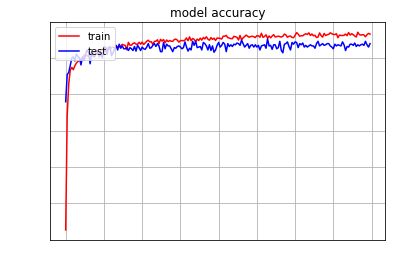

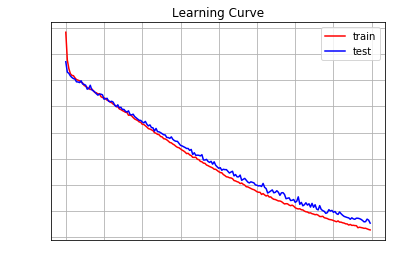

In [14]:
history.loss_plot('epoch')

In [15]:
import pandas as pd
# loading our save model
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
print('save_dir',save_dir)
print('model_path',model_path)
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('validate set loss:', scores[0])
print('validate set accuracy:', scores[1])

prediction=model.predict(x_test, batch_size=batch_size, verbose=0, steps=None)

yTest = [categorie[v] for v in np.argmax(y_test, axis=1)]
    
predictVector=np.argmax(prediction, axis=1)
predictions = [categorie[v] for v in predictVector]    

print(np.array(yTest).shape)
pd.crosstab(np.array(yTest) , np.array(predictions), rownames=['label'],colnames=['predict'])

save_dir /home/jovyan/projectME/saved_models
model_path /home/jovyan/projectME/saved_models/res50transfer_learning.h5
Loading trained model
1262/1262 [==============================] - 6s 5ms/step
validate set loss: 0.355779660485
validate set accuracy: 0.984944532488
(1262,)


predict,abnormal,normal
label,,
abnormal,405,7
normal,12,838


1803/1803 [==============================] - 5s 3ms/step


Test loss: 0.741262327018
Test accuracy: 0.916250693454


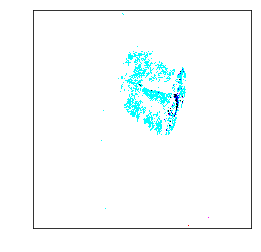

In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score

testImages, labels = load_data('datasets/test')
result=model.predict(testImages, verbose=0, steps=None)
scores = model.evaluate(testImages, np.eye(len(categorie))[labels], verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
labels = [categorie[v] for v in labels]
plt.imshow((testImages[0]*255).astype(np.uint8), cmap='gray')

In [17]:
predictVector=np.argmax(result, axis=1)
predictions = [categorie[v] for v in predictVector]
print(pd.crosstab(np.array(labels), np.array(predictions),
                      rownames=['label'], colnames=['predict']))
print(metrics.classification_report(np.array(labels), np.array(predictions)))    

predict   abnormal  normal
label                     
abnormal       577      11
normal         140    1075
             precision    recall  f1-score   support

   abnormal       0.80      0.98      0.88       588
     normal       0.99      0.88      0.93      1215

avg / total       0.93      0.92      0.92      1803



297/297 [==============================] - 1s 3ms/step
Test loss: 

0.708845459652
Test accuracy: 0.942760943363


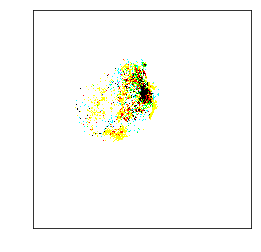

In [18]:
testImages, labels = load_data('datasets/nobackground')
result=model.predict(testImages, verbose=0, steps=None)
scores = model.evaluate(testImages, np.eye(2)[labels], verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
labels = [categorie[v] for v in labels]
plt.imshow(testImages[0]*255).astype(np.uint8), cmap='gray')

In [19]:
predictVector=np.argmax(result, axis=1)
predictions = [categorie[v] for v in predictVector]
print(pd.crosstab(np.array(labels), np.array(predictions),
                      rownames=['label'], colnames=['predict']))
print(metrics.classification_report(np.array(labels), np.array(predictions)))    

predict   abnormal  normal
label                     
abnormal        96       0
normal          17     184
             precision    recall  f1-score   support

   abnormal       0.85      1.00      0.92        96
     normal       1.00      0.92      0.96       201

avg / total       0.95      0.94      0.94       297

